# Results for Observation Data

This notebook creates evaluation metrics and graphs for Observation data that is outlined in the report

In [1]:
import os
os.chdir("..")

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from training.vit_unet import load_model as vit_unet_model
from training.unet import load_model as unet_model
from training.diffusion import load_model as diffusion_model

from dataloader.observation import create_df_list
from dataloader.observation import load_data
from dataloader.observation import data_stat

from inference.metrics import RelativeErrorObs

# Model comparision visualisation

In [3]:
# Create Random Validation images from different months

df_obs_val_list = create_df_list()
random.seed(42)  # Fix the seed

random_list=[]
for i in range(360,len(df_obs_val_list[0]),550*2+5):
    random_list.append(i)


rand_df_list = [df_obs_val_list[i].loc[random_list].reset_index(drop=True) for i in range(4)]
date_title = list(rand_df_list[0]['Date de début'].values)

In [4]:
dataset_polair_discrim = load_data(img_shape=(4,75,110), normalisation=False, df_obs_val_list=rand_df_list)
dataset_polair_generative = load_data(img_shape=(4,75,110), normalisation=True, df_obs_val_list=rand_df_list)

# DataLoader for Discriminative model
discrim_dataloader = DataLoader(dataset_polair_discrim, batch_size=8, shuffle=False) 

# DataLoader for Generative model
generative_dataloader = DataLoader(dataset_polair_generative, batch_size=8, shuffle=False) 

In [5]:
# Load models
img_size = (75,110)

vit_unet_model = vit_unet_model(img_size, load_checkpoint=True)
unet_model = unet_model(img_size, load_checkpoint=True)
diffusion_model = diffusion_model(img_size, load_checkpoint=True)

Loading existing model from :  model_weights/vit.pth
Loading existing model from :  model_weights/unet.pth
Loading existing model from :  model_weights/diffusion.pth


In [6]:
# Discriminative model
mask, vt, org_img = next(iter(discrim_dataloader))

# Vit+Unet model
predicted_images_vit = vit_unet_model.call_model(vt)
predicted_images_vit = predicted_images_vit.cpu()

# Unet model
predicted_images_unet = unet_model.call_model(vt)
predicted_images_unet = predicted_images_unet.cpu()

# Generative model
mask, vt, org_img = next(iter(generative_dataloader))

sample_img_diffusion = diffusion_model.ensemble_prediction(org_img, mask, vt, num_inf_steps=10, num_ensem_steps=20, device='cuda')[-1]

org_img = org_img.cpu()
sample_img_diffusion = sample_img_diffusion.cpu()
vt = vt.cpu()

In [10]:
# Create plot

def plot_result(vt, vit_pred, unet_pred, diff_pred, data_type, dict_meanstd, dict_minmax, date_title):
    f, ax = plt.subplots(4, 4, figsize=(11, 8))
    data_mean = dict_meanstd[data_type][0]
    data_std = dict_meanstd[data_type][1]
    data_min = dict_minmax[data_type][0]
    data_max = dict_minmax[data_type][1]
    title = ['obs_input', 'Discriminative(ViT+UNet)', 'Discriminative(UNet)', 'Diffusion']
    for i in range(4):
        plot_vt_input = vt[i+4]*data_std/0.5 + data_mean
        plot_vit = vit_pred[i+4]*(data_max-data_min) + data_min
        plot_unet = unet_pred[i+4]*(data_max-data_min) + data_min
        plot_prediction1 = diff_pred[i+4]*data_std/0.5 + data_mean

        im = [
            ax[0,i].imshow(plot_vt_input, vmin=0, vmax=plot_prediction1.max()),
            ax[1,i].imshow(plot_vit),
            ax[2,i].imshow(plot_unet),
            ax[3,i].imshow(plot_prediction1)
            ]
        
        for j in range(4):
            ax[j,i].axis('off')
            ax[j,i].set_title(title[j])
            cbar = f.colorbar(im[j], ax=ax[j,i])
        ax[0,i].set_title(date_title[i+4])

    plt.tight_layout()   
    plt.savefig(f'result/observation_data/visualise/{data_type}.svg')     
    


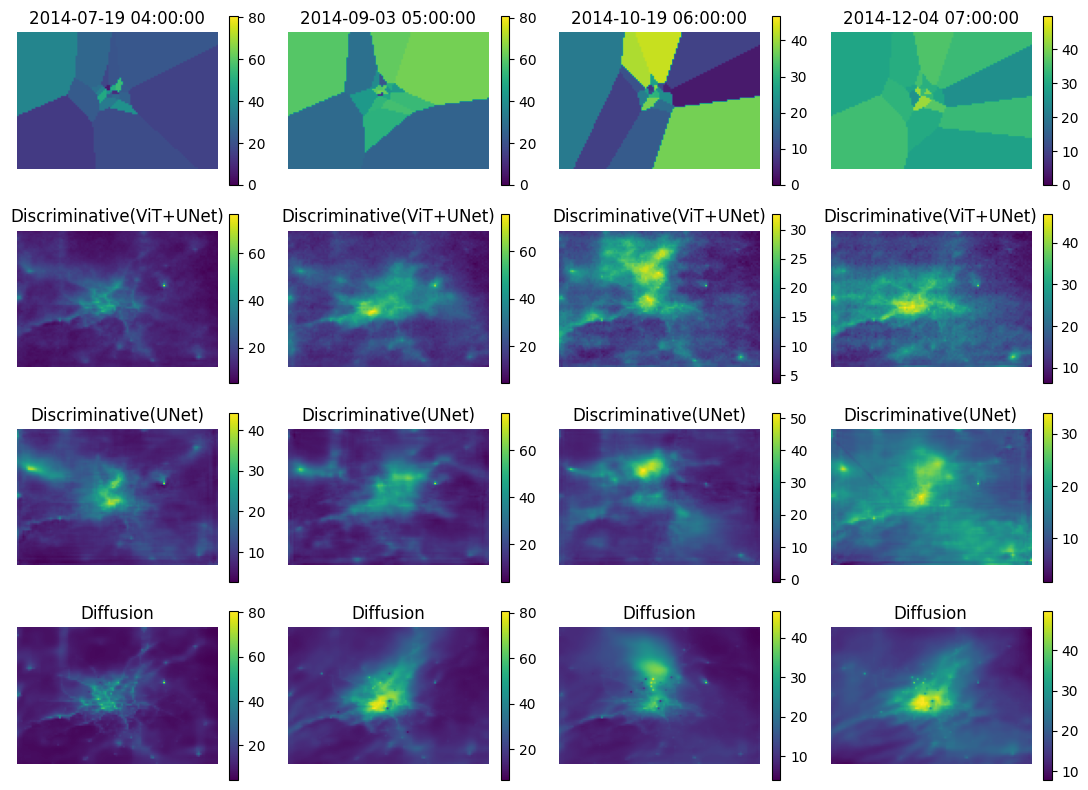

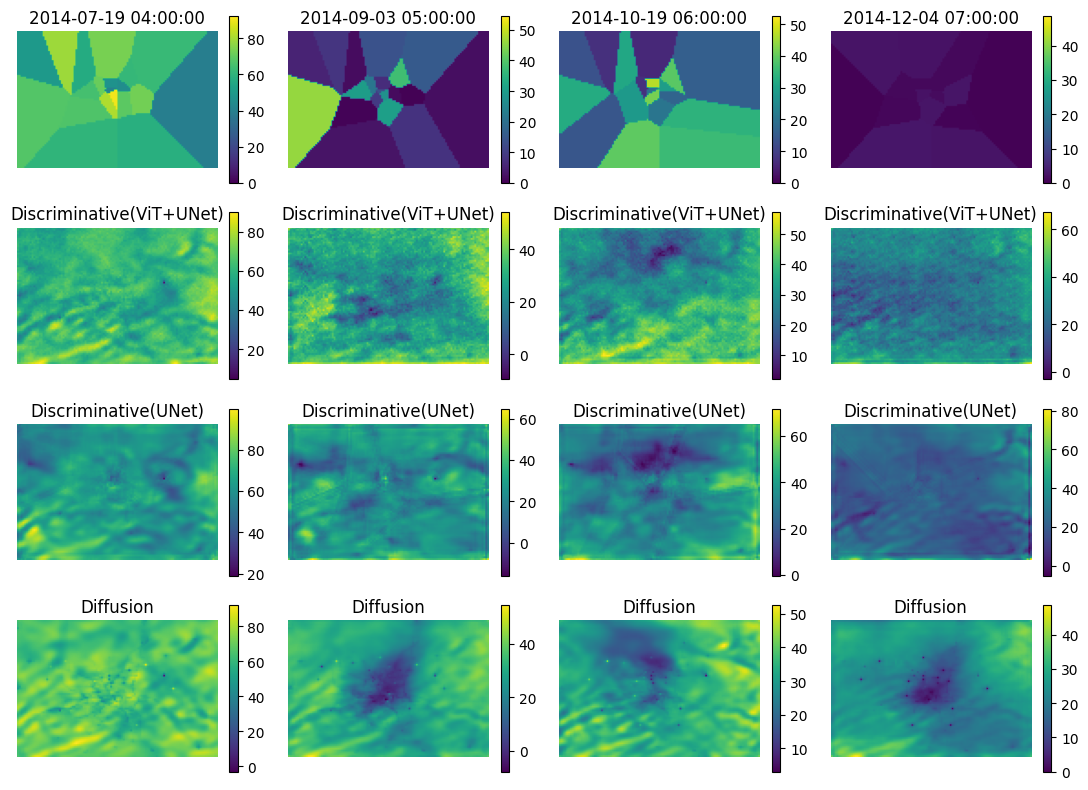

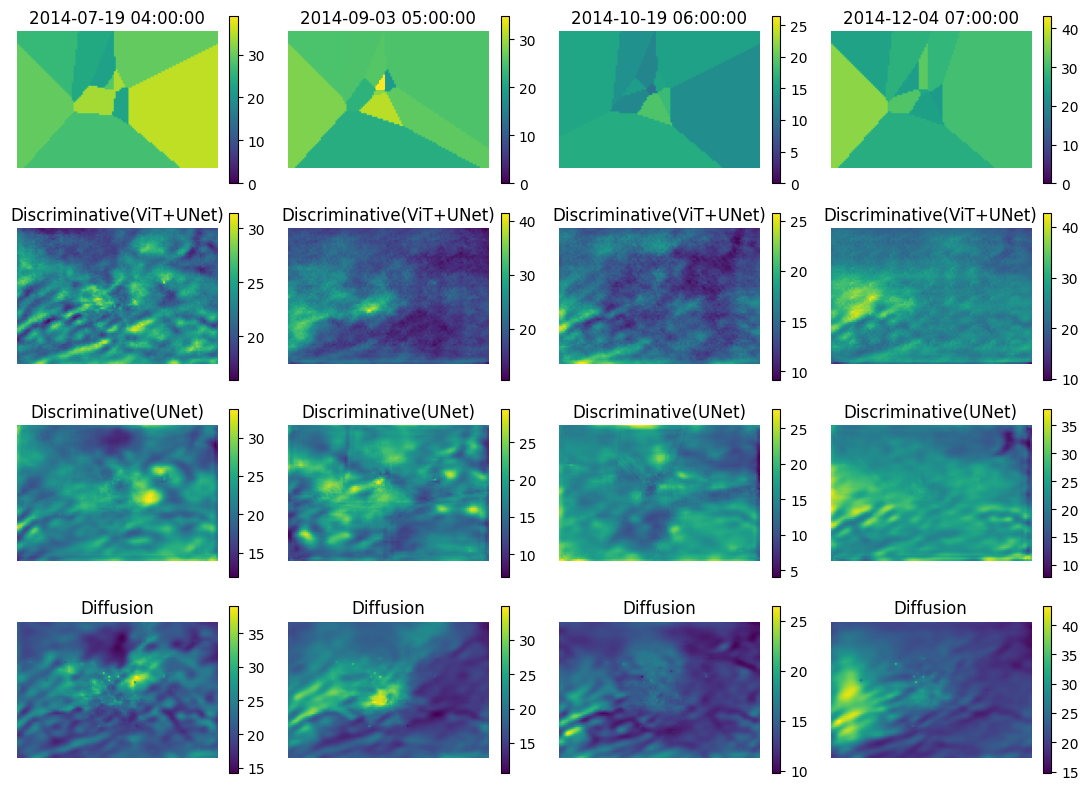

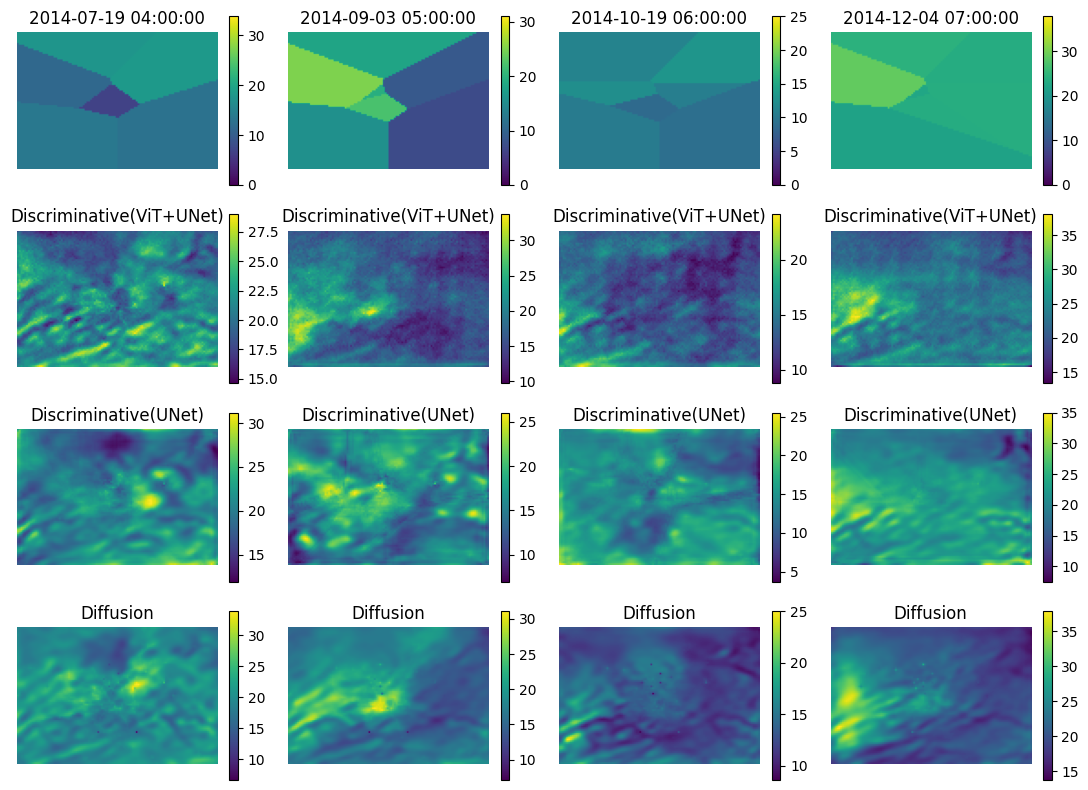

In [11]:
dict_minmax, dict_meanstd = data_stat()
for data_type in range(4):
    plot_result(vt[:,data_type,:,:], predicted_images_vit[:,data_type,:,:], predicted_images_unet[:,data_type,:,:], sample_img_diffusion[:,data_type,:,:], data_type, dict_meanstd, dict_minmax, date_title)

# Relative Error Histogram

In [3]:
dict_minmax, dict_meanstd = data_stat()

# Load models
img_size = (75,110)

vit_unet_model = vit_unet_model(img_size, load_checkpoint=True)
unet_model = unet_model(img_size, load_checkpoint=True)
diffusion_model = diffusion_model(img_size, load_checkpoint=True)

Loading existing model from :  model_weights/vit.pth
Loading existing model from :  model_weights/unet.pth
Loading existing model from :  model_weights/diffusion.pth


In [4]:
RelErrClass = RelativeErrorObs(dict_minmax, dict_meanstd)

# Discriminative Model

RelErrClass.calculate_error(vit_unet_model, 'vit_unet')
RelErrClass.calculate_error(unet_model, 'unet')

# Generative model inference time is high. Load the pre-calculated error

chan_rel_err = np.load("result/observation_data/relative_error/numpy_files/channel_relative_error_"+ 'diffusion' +".npz")
chan_rel_err = {int(k): chan_rel_err[k] for k in chan_rel_err.files}

all_rel_error = np.load('result/observation_data/relative_error/numpy_files/all_relative_error_'+ 'diffusion' +'.npy')

RelErrClass.create_channel_plot(chan_rel_err, 'diffusion')
RelErrClass.create_mean_plot(all_rel_error, 'diffusion')
